# Load data

In [1]:
import pandas as pd
import nltk 
import re
import string
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from langdetect import detect

In [2]:
# load data
hotel_df = pd.read_csv("7282_1.csv")

# some hundred ratings are above 5, so filter out below five & include five
hotel_df = hotel_df[hotel_df["reviews.rating"] <= 5]

# still have dicimal rating, so I round up
hotel_df["reviews.rating"] = round(hotel_df["reviews.rating"])

# drop not useful column
hotel_df=hotel_df.drop(["reviews.doRecommend","reviews.id"], axis=1)

# rename becasue it is easy to do study
hotel_df.rename(columns={'address': 'hotel_address', 'city': 'hotel_city',
                     'country':'hotel_country', 'name':'hotel_name'},
            inplace=True)

# pick the column that I will use.
hotel_df = hotel_df.loc[:,["province","reviews.date","hotel_address","hotel_city","hotel_country","hotel_name","reviews.rating","reviews.text"]]

# shuffle the data.
hotel_df = hotel_df.reindex(np.random.permutation(hotel_df.index)) 


In [3]:
#total number of unique hotels
len(hotel_df.hotel_name.unique())

793

# Check Missing Value

In [4]:
# Check the missing value
hotel_df.isnull().sum()

province            0
reviews.date      259
hotel_address       0
hotel_city          0
hotel_country       0
hotel_name          0
reviews.rating      0
reviews.text       22
dtype: int64

# Preprocessing data

In [5]:
hotel_df["reviews.text"] = hotel_df.loc[:,"reviews.text"].replace("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx", float("NaN"))
hotel_df= hotel_df.dropna(subset = ["reviews.text","province","reviews.date", "reviews.rating"], how = "any")
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
def cleaning_text(corpus):
    corpus = re.sub("#", "", corpus)
    corpus = re.sub("@", "", corpus)
    corpus = re.sub("http?:\/\/\S+","",corpus)
    corpus = re.sub("n't", " not", corpus)
    corpus = re.sub("'ll", " will", corpus)
    corpus = re.sub("'s", " is", corpus)
    corpus = re.sub("'re", " are", corpus)
    corpus = re.sub("'m", " am", corpus)
    corpus = re.sub("�", "", corpus)
    corpus = corpus.lower()
    
    no_str_punc_corpus = "".join([word for word in corpus if word not in string.punctuation])
    cleaned_text = []
    for word in corpus.split():
        if word not in stopwords:
            if re.match("[a-zA-Z]+", word):
                cleaned_text.append(word)
    sentences = " ".join([word for word in cleaned_text])
    
    return sentences        

In [6]:
hotel_df["cleaned_text"] = hotel_df['reviews.text'].apply(lambda x: cleaning_text(x))

In [7]:
hotel_df["cleaned_text"] = hotel_df["cleaned_text"].replace("",float("NaN"))
hotel_df["cleaned_text"] = hotel_df["cleaned_text"].replace(". .", float("NaN"))
hotel_df= hotel_df.dropna(subset = ["cleaned_text"], how = "any")
hotel_df.isnull().sum()

province          0
reviews.date      0
hotel_address     0
hotel_city        0
hotel_country     0
hotel_name        0
reviews.rating    0
reviews.text      0
cleaned_text      0
dtype: int64

In [162]:
hotel_df["language"] = hotel_df["cleaned_text"].apply(detect)
hotel_df = hotel_df[hotel_df['language']=='en']

# Sentiment Analysis

In [49]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentiment = hotel_df['reviews.text'].apply(lambda x: analyzer.polarity_scores(x))
hotel_df = pd.concat([hotel_df,sentiment.apply(pd.Series)],1)

In [52]:
def output(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    else:
        return 'Negative'
    
hotel_df["Analysis"] = hotel_df["compound"].apply(output)

In [54]:
print('Number of Positve tagged sentences is:  {}'.format(len(hotel_df[hotel_df["Analysis"]=='Positive'])))
print('Number of Negative tagged sentences is: {}'.format(len(hotel_df[hotel_df["Analysis"]=='Negative'])))
print('Total length of the data is:          {}'.format(hotel_df.shape[0]))

Number of Positve tagged sentences is:  26011
Number of Negative tagged sentences is: 8599
Total length of the data is:          34610


# datetime

In [163]:
def clean_datetime(string):
    results = string.replace("T00:00:00Z","")
    return results
hotel_df["reviews.date"] = hotel_df["reviews.date"].apply(clean_datetime)


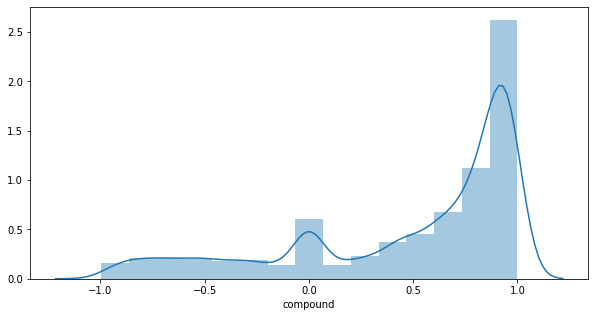

In [69]:
import seaborn as sns
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.distplot(hotel_df['compound'], bins=15, ax=ax)
plt.show()

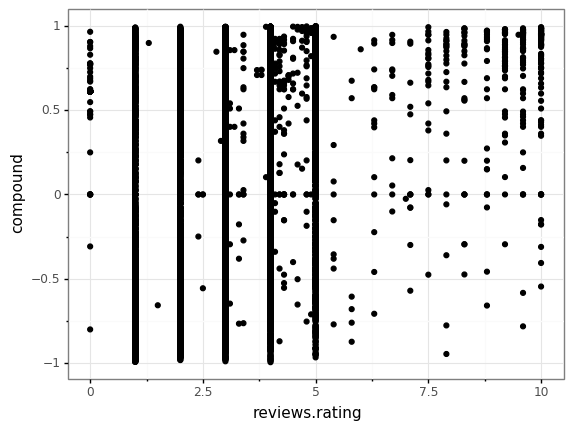

<ggplot: (-9223371845045040788)>

In [161]:
from plotnine import *
%matplotlib inline

ggplot(hotel_df, aes(x='reviews.rating', y='compound')) + geom_point()+theme_bw()

# test linear regression assumption

In [175]:
df = hotel_df[["reviews.rating", "compound"]]
df["reviews_rating"] = df.loc[:,["reviews.rating"]]
df

C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviews.rating,compound,reviews_rating
0,4.0,0.8299,4.0
1,5.0,0.9828,5.0
2,5.0,0.0000,5.0
3,5.0,0.9643,5.0
4,5.0,0.9643,5.0
...,...,...,...
35905,5.0,0.9813,5.0
35906,5.0,0.8271,5.0
35907,5.0,0.9888,5.0
35908,5.0,0.9759,5.0


In [176]:
import statsmodels.formula.api as smf
reg = smf.ols('reviews_rating ~ compound', data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         reviews_rating   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Thu, 02 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:46:29   Log-Likelihood:                -54484.
No. Observations:               34599   AIC:                         1.090e+05
Df Residuals:                   34597   BIC:                         1.090e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1632      0.008    381.908      0.000       3.147       3.179
compound       1.3382      0.011    118.354      0.000       1.316       1.360
==============================================================================
Omnibus:                     3229.323   Durbin-Watson:                   1.358
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17468.096
Skew:                           0.289   Prob(JB):                         0.00
Kurtosis:                       6.433   Cond. No.                         2.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# see correlation

In [ ]:
plotCorrelationMatrix(df1, 8)

# Step 1. Linearity & Equal variance

From the below part, it seems random

In [ ]:
pred_val = reg.fittedvalues.copy()
true_val = df["reviews_rating"].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
scatter_plot= ax.scatter(residual, pred_val)

In [185]:
import statsmodels.stats.api as sms
import numpy as np
import statsmodels
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sms.linear_harvey_collier(reg)

Ttest_1sampResult(statistic=-1.8010068467411677, pvalue=0.07171050595373127)

In [186]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(residual, df[['compound']])
pval, f_pval

(nan, 1.009381780324e-312)

0.94166691392278

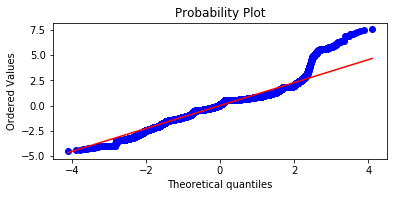

In [187]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

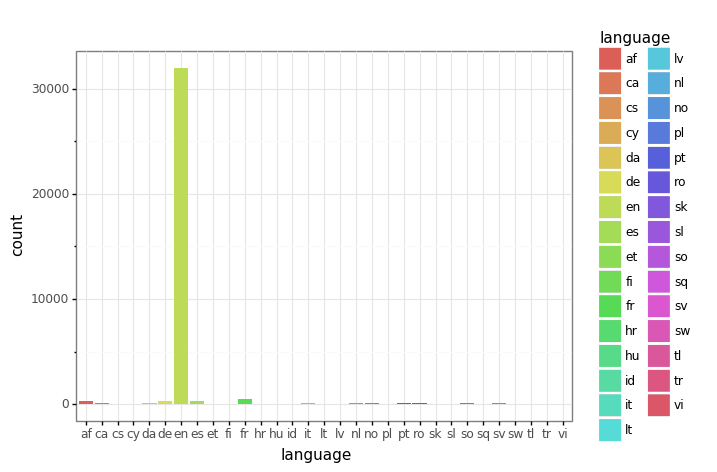

<ggplot: (-9223371845039541572)>

In [149]:
ggplot(hotel_df, aes(x = "language", fill = 'language')) + \
    geom_bar(stat = 'count')+ \
    theme_bw()

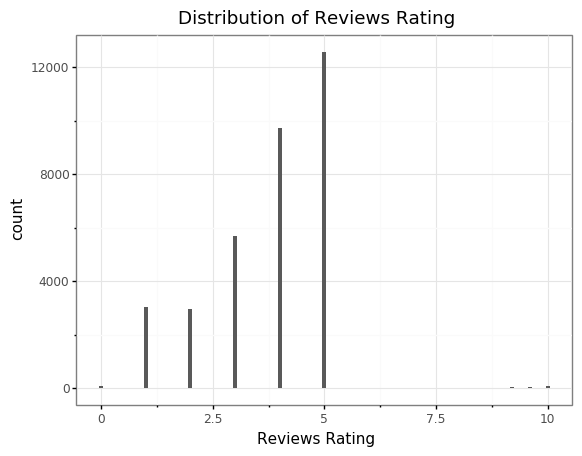

<ggplot: (-9223371845051980128)>

In [158]:
ggplot(hotel_df, aes(x = "reviews.rating")) + \
    geom_bar() + \
    theme_bw() +\
    xlab("Reviews Rating") + \
    ggtitle("Distribution of Reviews Rating")

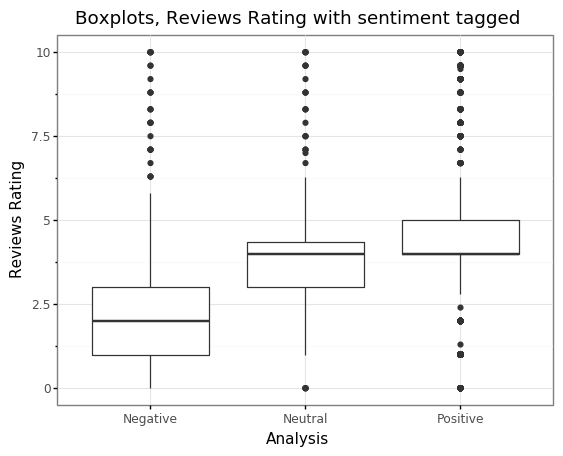

<ggplot: (-9223371845045044724)>

In [159]:
ggplot(hotel_df, aes(x = "Analysis", y = "reviews.rating")) + \
    geom_boxplot() + \
    theme_bw() + \
    ylab("Reviews Rating") + \
    ggtitle("Boxplots, Reviews Rating with sentiment tagged")

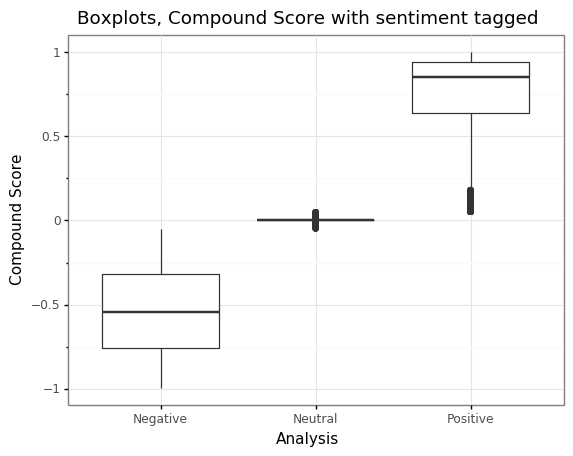

<ggplot: (-9223371845046088500)>

In [160]:
ggplot(hotel_df, aes(x = "Analysis", y = "compound")) + \
    geom_boxplot() + \
    theme_bw() + \
    ylab("Compound Score") + \
    ggtitle("Boxplots, Compound Score with sentiment tagged")

# vacation analysis

In [33]:
hotel_df = hotel_df[hotel_df["hotel_city"] != 'Curitiba']
statesList = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(hotel_df['reviews.text'])
bag_of_words = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [42]:
bag_of_words

,00,000,00am,00pm,10,100,101,109,10am,10min,...,zero,zimmer,zion,zip,zona,zone,zoo,zu,zum,zur
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34685,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Join our bag of words back to our initial hotel data
full_df = hotel_df.join(bag_of_words)

In [38]:
# X is our words
X = bag_of_words

# Y is our hotel name (the outcome we care about)
Y_hotel = hotel_df['hotel_name']

In [39]:
rfc = RandomForestClassifier()

# Fit that random forest model to our data
rfc.fit(X,Y_hotel)

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# wrtie your onw dream hotel

In [40]:
hotel_df

,hotel_address,categories,hotel_city,hotel_country,latitude,longitude,hotel_name,postalCode,province,reviews.date,reviews.dateAdded,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince,cleaned_text
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN,Pleasant min walk along sea front Water Bus. r...
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN,Really lovely hotel. Stayed top floor surprise...
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN,Ett mycket bra hotell. Det som drog ner betyge...
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN,We stayed four nights October. The hotel staff...
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN,We stayed four nights October. The hotel staff...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35905,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2016-07-06T00:00:00Z,2016-06-23T16:50:58Z,5.0,We truly enjoyed staying at the Elk Springs re...,We Loved It!,Charlotte,randolphtiffany,NC,We truly enjoyed staying Elk Springs resort! I...
35906,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2016-05-02T00:00:00Z,2016-06-23T16:50:58Z,5.0,We were here for a 2nd time the last weekend o...,Amazing time (both times!!),Charlotte,Sabrina P,NC,We time last weekend April stayed Deer Heart c...
35907,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2012-03-20T00:00:00Z,2016-06-23T16:50:58Z,5.0,Best of the Best!!!! My family and I stayed in...,Amazing time (both times!!),Charlotte,Chelsa K.,NC,Best Best!!!! My family I stayed Grin Bear It ...
35908,1088 Powdermill Rd,"Cabins,Resorts & Vacation Cottages,Wedding Cha...",Gatlinburg,US,35.754868,-83.457295,Elk Springs Resort,37738,TN,2012-03-12T00:00:00Z,2016-06-23T16:50:58Z,5.0,Amazing Vacation in Beautiful Cabin We stayed ...,Amazing time (both times!!),Charlotte,Heather D.,NC,Amazing Vacation Beautiful Cabin We stayed lon...


In [41]:
test_review = ['''
    I loved the beach and the sunshine and the clean and modern room.
    ''']
# Convert your test review into a vector
X_test = vectorizer.transform(test_review).toarray()
#Match your review
prediction = rfc.predict(X_test)[0]
# Return the essential information about your match
hotel_df[hotel_df['hotel_name'] == prediction][['hotel_name', 'hotel_address', 
                                        'hotel_city', 'hotel_country']].head(1)

,hotel_name,hotel_address,hotel_city,hotel_country
20565,Ip Casino Resort Spa,850 Bayview Ave,Biloxi,US


# Machine learning

# Logistic

Logistic CV ngram(1,2) 

In [13]:
run_ML = hotel_df.loc[:,["reviews.rating", "cleaned_text"]]
def logistic(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42)
    classf = LogisticRegression()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("Logistic Regression:",accuracy_score(y_test, pred))
    return(y_test, pred)
cv = CountVectorizer(ngram_range = (1,2))
x_cv = cv.fit_transform(run_ML["cleaned_text"])
logistic(x_cv,run_ML['reviews.rating'])

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression: 0.5156814737087559


(31234    4.0
 27477    3.0
 35467    2.0
 19073    4.0
 33809    4.0
         ... 
 1        5.0
 30291    5.0
 18783    5.0
 35167    5.0
 30793    3.0
 Name: reviews.rating, Length: 8577, dtype: float64,
 array([5., 5., 2., ..., 5., 5., 3.]))

Logistic tf-idf

In [10]:
vect = TfidfVectorizer()
x_vect = vect.fit_transform(run_ML['cleaned_text'])
logistic(x_cv,run_ML['reviews.rating'])

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression: 0.5156814737087559


(31234    4.0
 27477    3.0
 35467    2.0
 19073    4.0
 33809    4.0
         ... 
 1        5.0
 30291    5.0
 18783    5.0
 35167    5.0
 30793    3.0
 Name: reviews.rating, Length: 8577, dtype: float64,
 array([5., 5., 2., ..., 5., 5., 3.]))

Logistic tf-idf with ngram 1,2

In [169]:
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect = vect.fit_transform(run_ML['cleaned_text'])
logistic(x_cv,run_ML['reviews.rating'])

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression: 0.5229781771501926


(6466     5.0
 6996     3.0
 8571     5.0
 33585    1.0
 21487    5.0
         ... 
 19012    4.0
 19217    5.0
 2269     5.0
 16476    3.0
 32976    5.0
 Name: reviews.rating, Length: 7790, dtype: float64,
 array([3., 4., 5., ..., 5., 4., 4.]))

# Linear support vector machine

CV with ngram

In [170]:
def linsvc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42)
    classf = LinearSVC()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("Linear SVC:",accuracy_score(y_test, pred))
    return(y_test, pred)
vect = CountVectorizer(ngram_range=(1,2))
x_vect = vect.fit_transform(run_ML['cleaned_text'])
linsvc(x_vect,run_ML['reviews.rating'])

Linear SVC: 0.49550706033376124


C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(6466     5.0
 6996     3.0
 8571     5.0
 33585    1.0
 21487    5.0
         ... 
 19012    4.0
 19217    5.0
 2269     5.0
 16476    3.0
 32976    5.0
 Name: reviews.rating, Length: 7790, dtype: float64,
 array([4., 4., 5., ..., 5., 4., 5.]))

tf-idf with ngram

In [12]:
vect = TfidfVectorizer(ngram_range=(1,2),stop_words = "english", max_features = 100000)
x_vect = vect.fit_transform(run_ML['cleaned_text'])
linsvc(x_vect,run_ML['reviews.rating'])

NameError: name 'linsvc' is not defined

# Random Forest

CV

In [179]:
def random_forest(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42)
    classf = RandomForestClassifier(criterion="entropy")
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("Random Forest:",accuracy_score(y_test, pred))
    return(y_test, pred)
cv = CountVectorizer()
x_cv = cv.fit_transform(run_ML["cleaned_text"])
random_forest(x_cv,run_ML['reviews.rating'])

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest: 0.44146341463414634


(6466     5.0
 6996     3.0
 8571     5.0
 33585    1.0
 21487    5.0
         ... 
 19012    4.0
 19217    5.0
 2269     5.0
 16476    3.0
 32976    5.0
 Name: reviews.rating, Length: 7790, dtype: float64,
 array([4., 4., 4., ..., 5., 1., 5.]))

In [180]:
cv = CountVectorizer(ngram_range=(1,2))
x_cv = cv.fit_transform(run_ML["cleaned_text"])
random_forest(x_cv,run_ML['reviews.rating'])

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest: 0.43594351732991016


(6466     5.0
 6996     3.0
 8571     5.0
 33585    1.0
 21487    5.0
         ... 
 19012    4.0
 19217    5.0
 2269     5.0
 16476    3.0
 32976    5.0
 Name: reviews.rating, Length: 7790, dtype: float64,
 array([5., 4., 5., ..., 5., 1., 5.]))

tf-idf

In [183]:
tf = TfidfVectorizer(ngram_range=(1,2))
x_tf = tf.fit_transform(run_ML["cleaned_text"])
random_forest(x_tf,run_ML['reviews.rating'])

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest: 0.43414634146341463


(6466     5.0
 6996     3.0
 8571     5.0
 33585    1.0
 21487    5.0
         ... 
 19012    4.0
 19217    5.0
 2269     5.0
 16476    3.0
 32976    5.0
 Name: reviews.rating, Length: 7790, dtype: float64,
 array([5., 5., 4., ..., 4., 2., 5.]))

# NB

In [188]:
from sklearn.naive_bayes import BernoulliNB
def Bernoulli_NB(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42)
    classf = BernoulliNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("BernoulliNB:",accuracy_score(y_test, pred))
    return(y_test, pred)

CV with ngram

In [189]:
cv = CountVectorizer(ngram_range = (1,2))
x_cv = cv.fit_transform(run_ML["cleaned_text"])
Bernoulli_NB(x_cv,run_ML['reviews.rating'])

BernoulliNB: 0.3982028241335045


(6466     5.0
 6996     3.0
 8571     5.0
 33585    1.0
 21487    5.0
         ... 
 19012    4.0
 19217    5.0
 2269     5.0
 16476    3.0
 32976    5.0
 Name: reviews.rating, Length: 7790, dtype: float64,
 array([5., 5., 5., ..., 5., 4., 5.]))

TF-IDF with ngram

In [193]:
tf = TfidfVectorizer()
x_cv = tf.fit_transform(run_ML["cleaned_text"])
Bernoulli_NB(x_cv,run_ML['reviews.rating'])

BernoulliNB: 0.49987163029525034


(6466     5.0
 6996     3.0
 8571     5.0
 33585    1.0
 21487    5.0
         ... 
 19012    4.0
 19217    5.0
 2269     5.0
 16476    3.0
 32976    5.0
 Name: reviews.rating, Length: 7790, dtype: float64,
 array([4., 5., 5., ..., 5., 2., 4.]))

# SVC

In [195]:
def svc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42)
    classf = SVC()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("SVC:",accuracy_score(y_test, pred))
    return(y_test, pred)

# CV with ngram

In [196]:
cv = CountVectorizer(ngram_range = (1,2))
x_cv = cv.fit_transform(run_ML["cleaned_text"])
svc(x_cv,run_ML['reviews.rating'])

C:\Users\Jack\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC: 0.3600770218228498


(6466     5.0
 6996     3.0
 8571     5.0
 33585    1.0
 21487    5.0
         ... 
 19012    4.0
 19217    5.0
 2269     5.0
 16476    3.0
 32976    5.0
 Name: reviews.rating, Length: 7790, dtype: float64,
 array([5., 5., 5., ..., 5., 5., 5.]))

# TF-IDF with ngram